# Model the early Punic Individuals from all sites, with 2 outliers removed

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
os.sys.path.append(path)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-a-17-116.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


### Do qpAdm Function Imports and Definitions

In [2]:
from python.run_qpadm import qpAdm_run, get_meta_ind_table, modifiy_iid_files, set_iids_to_label
from python.plot_qpadm import plot_qpadm

### Parameters for qpAdm_run are set there!
a12 = ["Mota", "Ust_Ishim", "Kostenki14", "GoyetQ116-1", "Vestonice16", "MA1",
           "ElMiron", "Villabruna", "EHG", "CHG", "Natufian",
           "Levant_N"] # List of ancient European populations for right populations
distal = ["Anatolia_N", "WHG", "Steppe_EMBA", 
          "Iran_N", "Morocco_EN.SG"]
print(f"# Anc_Euro: {len(a12)} populations")
print(f"# Distal sources:{len(distal)} populations")

# Anc_Euro: 12 populations
# Distal sources:5 populations


# 1) Modify .ind File

### Optional: Screen for Population Lables in anno file

In [29]:
vrs = "49.2"
df = get_meta_ind_table(path_ind = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind",
                        path_anno = f"/n/groups/reich/hringbauer/Data/v{vrs}.anno.csv",
                        min_snp = 30000)
### Screen for what one wants
df[df["clst"].str.contains("Morocco")]["clst"].value_counts()

Filtering to 1137/1142
Loaded 1137 Individuals
Filtered to 1091 Individuals based on #SNP covered> 30000
Filtered to 1002 Individuals based on duplicates.


Morocco_Iberomaurusian                   6
Morocco_LN.SG                            3
Morocco_EN.SG                            3
Morocco_unknown.SG                       1
Morocco_Iberomaurusian_sibling.TAF011    1
Name: clst, dtype: int64

### 1a) Prepare Early Punic Individuals
Load data table with individual assignments - and produce modified .ind file for use in qpadm

In [16]:
### Populations to overwrite. Typically because they have the ".SG" label
ind_merged = f"./eigenstrat/anc_only.v{vrs}_outgroups.ind"          # What .ind to load
ind_modified = f"./eigenstrat/anc_only.v{vrs}.punic_early.ind"    # Where to save the modified version to

df_ind = pd.read_csv(ind_merged, delim_whitespace=True, header=None)
df_ind.columns=["iid", "sex", "clst"]
print(f"Loaded {len(df_ind)} Individuals")

df_lbs = pd.read_csv("./data/cluster_assignments_punic.v49.2.tsv", sep="\t")  ### Load external Label file (Google docs)

### Reset Clusters
for _, row in df_lbs.iterrows():
    iid = row['iid']
    
    idx = df_ind["iid"] == iid
    if np.sum(idx)<1:
        print(f"Warning, {iid} not found in original .ind file.")
    
    df_ind.loc[idx, "clst"] = row["clst_qpadm"]
    ### Reset All the Individuals in the Target Ind
    #df_ind = set_iids_to_clst(df_ind, iids=iids, clst=g, savepath="")
    
#df_ind[df_ind["clst"].str.contains("CentralMed")]  
df_ind.to_csv(ind_modified, header=False, sep=" ", index=False)
print(f"Saved updated {len(df_ind)} IIDs to: {ind_modified}")

Loaded 1142 Individuals
Warning, I26842 not found in original .ind file.
Saved updated 1142 IIDs to: ./eigenstrat/anc_only.v49.2.punic_early.ind


### Update other labels in Ind file

In [9]:
iids = df_ind[df_ind["clst"] == "PunicCentralMedEarly"]

In [10]:
len(iids)

18

# 2) Run qpAdm

## 2a) Distal Modelling

### Run for single Population
Here: Run for Morocco_EN with Morocco_Iberomaurusian as Outgroup.
Idea: Very distal model, compared to Algeria_IA, which is explored in the full proximal model

In [33]:
%%time

target = "PunicCentralMedEarly"  
sources = ["Morocco_EN.SG", "WHG", "Steppe_EMBA", "Anatolia_N", "Iran_N"]  # Morocco_EN.SG, Algeria_IA
rightpops = a12 + ["Morocco_Iberomaurusian"] 

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 99.532556
CPU times: user 6.98 ms, sys: 7.07 ms, total: 14.1 ms
Wall time: 1min 39s


0

### Run distal Models for all Reference Populations of Interest

In [ ]:
%%time

target = "PunicCentralMedEarly"  
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "Algeria_IA", "Iran_N"]  # Morocco_EN.SG, Algeria_IA
rightpops = a12 + ["Morocco_EN.SG"]

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

### 2b) Distal Modelling for all source groups of interest

In [10]:
%%time

targets = ["PunicCentralMedEarly", "Algeria_IA", 
           "Italy_Sicily_IA_Polizzello", 
           "Greece_BA_Mycenaean", "Spain_IA", "Italy_Sardinia_BA_Nuragic",
           "Israel_Phoenician", "Israel_C", "Israel_MLBA"]

sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "Morocco_EN.SG", "Iran_N"]  # Morocco_EN.SG, Tunisia_LN for African possible
rightpops = a12 # + ["Morocco_EN.SG"] ### Remove Morocco_EN.SG from Outgroup if in Source

for target in targets:
    leftpops = [target] + sources
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops), 
              input_folder = "./eigenstrat/", 
              input_file = "anc_only.v49.2",
              input_ind_suff = ".punic_early",
              par_file_folder = "./parfiles/", 
              output_folder = "./output/qpAdm/v49.2/distal_grouped/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=False)

Runtime: 71.884755
Runtime: 70.173747
Runtime: 71.585433
Runtime: 69.511715
Runtime: 72.323834
Runtime: 70.767218
Runtime: 71.703620
Runtime: 71.513078
Runtime: 73.455270
CPU times: user 35.4 ms, sys: 66.7 ms, total: 102 ms
Wall time: 10min 43s


## 1,2,3-way models of proximal sources for "PunicCentralMedEarly"
No 1 or 2-way model of the expected sources work. p<<1e-5

Two fitting 3-way models:

Algeria_IA/Sicily_IA/Mycenean
p=0.0273     0.070     0.619     0.311

Algeria_IA/Mycenean/Spain_IA
p=0.122     0.089     0.654     0.257

To follow up on that add each of them as outgroup for the other [to be done]



In [18]:
%%time

### "Italy_Sicily_IA_Polizzello", "Israel_Phoenician",
srcs_pot = ["Spain_IA", "Greece_BA_Mycenaean", "Algeria_IA"]
target = "PunicCentralMedEarly" 
rightpops = a12 + ["Morocco_EN.SG", "Iran_N", "Israel_Phoenician"]
# Added Phoenician as Outgroup to get that across

### Iterate over all pairs
for p in it.combinations(srcs_pot, r=3):  ### One run was with r=1
    leftpops = [target] + list(p)
    qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
              output_file = ".".join(leftpops), 
              input_folder = "./eigenstrat/", 
              input_file = "anc_only.v49.2",
              input_ind_suff = ".punic_early",
              par_file_folder = "./parfiles/", 
              output_folder = "./output/qpAdm/v49.2/early_punic_proxi/", 
              path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
              all_snps=False)

Runtime: 76.589441
CPU times: user 4.89 ms, sys: 7.48 ms, total: 12.4 ms
Wall time: 1min 16s


### Follow up on the two three-way models
They are different in their third source (Spain_IA/Italy_Sicily_IA_Polizzello).
Put each of them as outgroup for each other

### Result:
Only one model survives!!


Algeria_IA Mycenean Spain_IA

p=0.134404     0.086     0.661     0.253

and

Algeria_IA Mycenean Sicilly-Polizello

p=0.00349    0.077     0.442     0.481 

In [106]:
%%time

target = "PunicCentralMedEarly"  
sources = [ "Greece_BA_Mycenaean", "Italy_Sicily_IA_Polizzello"]  # Flip last component with down
rightpops = a12 + ["Morocco_EN.SG", "Iran_N", "Israel_Phoenician"] # Flip last component with up

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 60.914796
CPU times: user 4.01 ms, sys: 9.5 ms, total: 13.5 ms
Wall time: 1min


0

### 4-way proximal model for PunicCentralMedEarly
As another way to test Spain_IA vrs Polizello


Algeria_IA Greece_BA_Mycenaean Italy_Sicily_IA_Polizzello Spain_IA
p=0.136     0.082     0.453     0.310     0.156 

In [111]:
%%time

target = "PunicCentralMedEarly"  
sources = ["Algeria_IA", "Greece_BA_Mycenaean", "Italy_Sicily_IA_Polizzello", "Spain_IA"]  # Flip last component with down
rightpops = a12 + ["Morocco_EN.SG", "Iran_N"] # Flip last component with up

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 66.953734
CPU times: user 2.9 ms, sys: 12.1 ms, total: 15 ms
Wall time: 1min 6s


0

## Run proximal Model for plot of 3 Sources in Paper

In [34]:
%%time

### "Italy_Sicily_IA_Polizzello", "Israel_Phoenician",
srcs_pot = ["Algeria_IA", "Spain_IA", "Greece_BA_Mycenaean"]
target = "PunicCentralMedEarly" 
rightpops = a12 + ["Morocco_EN.SG", "Italy_Sicily_IA_Polizzello", "Israel_Phoenician"] #"Iran_N"
# Added Phoenician as Outgroup to get across it fits that way

leftpops = [target] + srcs_pot
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 81.713625
CPU times: user 3.61 ms, sys: 10.4 ms, total: 14 ms
Wall time: 1min 21s


0

# 3) Plot Results

### 3)a) Plot single distal Model for Punic Early
Really good fit - Iran N needed (when put in outgroup model does not fit)
All components "Anatolia_N", "WHG", "Steppe_EMBA", "Algeria_IA", "Iran_N" needed.

Generally low standard errors (0-2%) - good model.

Definitely WHG in there (which is very low in Myceneans)

Saved to ./figures/qpAdm.49.2/fig2/punic_early_distal.pdf


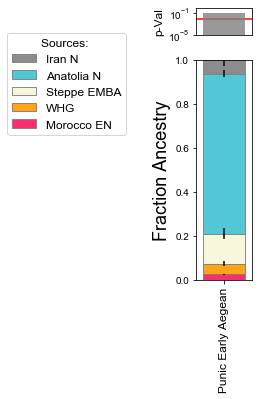

In [6]:
### Load the ancient Individual Label Data

t = "PunicCentralMedEarly"
#sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "Iran_N", "Morocco_EN.SG"]
sources = ["Morocco_EN.SG", "WHG", "Steppe_EMBA", "Anatolia_N", "Iran_N"]
paths = [".".join([t]+sources)]

dir_path = f"./output/qpAdm/v49.2/area51/"
save_path = "./figures/qpAdm.49.2/fig2/punic_early_distal.pdf" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#FF165D", "#FF9A00", "#F6F7D7", "#3EC1D3", "gray"]

xlabels = ["Punic Early Aegean"]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Morocco EN", "WHG", "Steppe EMBA", "Anatolia N", "Iran N"],
           best=False, pval_lim = [1e-5,1], figsize=(1,5), bw=0.9, lw=1.5, sgfc=0.01, 
           fs=12, c=c, ec="gray", l_pos=(-1.15, 1.15))

Saved to ./figures/qpAdm.49.2/PunicCentralMedEarly/4way_distal.pdf


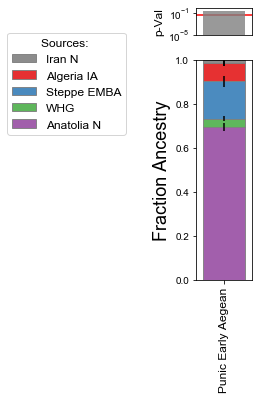

In [9]:
### Load the ancient Individual Label Data

t = "PunicCentralMedEarly"
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "Algeria_IA", "Iran_N"]
paths = [".".join([t]+sources)]

dir_path = f"./output/qpAdm/v49.2/area51/"
save_path = "./figures/qpAdm.49.2/PunicCentralMedEarly/4way_distal.pdf" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#984ea3", "#4daf4a", "#377eb8", "#e41a1c", "gray"]

xlabels = ["Punic Early Aegean"]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Anatolia N", "WHG", "Steppe EMBA", "Algeria IA", "Iran N"],
           best=False, pval_lim = [1e-5,1], figsize=(1,5), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-1.15, 1.15))

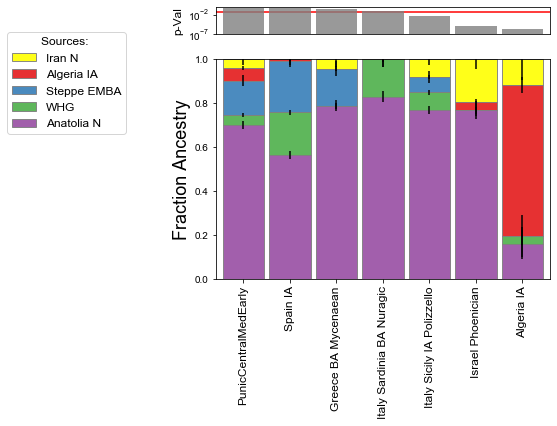

In [4]:
targets = ["PunicCentralMedEarly", "Algeria_IA", 
           "Italy_Sicily_IA_Polizzello", 
           "Greece_BA_Mycenaean", "Spain_IA", "Italy_Sardinia_BA_Nuragic",
           "Israel_Phoenician"]

sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "Tunisia_LN", "Iran_N"]
paths = [".".join([t]+sources) for t in targets]

dir_path = f"./output/qpAdm/v49.2/distal_grouped/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#984ea3", "#4daf4a", "#377eb8", "#e41a1c", "yellow"]

xlabels = [t.replace("_", " ") for t in targets]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Anatolia N", "WHG", "Steppe EMBA", "Algeria IA", "Iran N"],
           best=True, pval_lim = [1e-7,1], figsize=(6,5), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.25, 1.15))

### Distal Model for various source pops
This is the same plot as above, but this time with Tunisia_EN as N.Afr. source

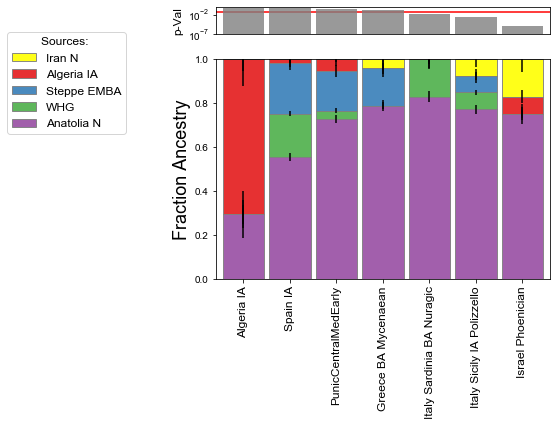

In [17]:
targets = ["PunicCentralMedEarly", "Algeria_IA", 
           "Italy_Sicily_IA_Polizzello", 
           "Greece_BA_Mycenaean", "Spain_IA", "Italy_Sardinia_BA_Nuragic",
           "Israel_Phoenician"]

sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "Morocco_EN.SG", "Iran_N"]

paths = [".".join([t]+sources) for t in targets]

dir_path = f"./output/qpAdm/v49.2/distal_grouped/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#984ea3", "#4daf4a", "#377eb8", "#e41a1c", "yellow"]

xlabels = [t.replace("_", " ") for t in targets]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Anatolia N", "WHG", "Steppe EMBA", "Algeria IA", "Iran N"],
           best=True, pval_lim = [1e-7,1], figsize=(6,5), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-0.25, 1.15))

### 3)b) Plot proximal Models

### Plot single Model [For Figure 2]

Saved to ./figures/qpAdm.49.2/fig2/punic_early_proximal.pdf


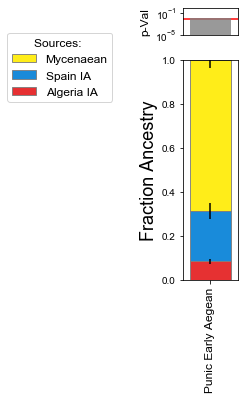

In [5]:
### Load the ancient Individual Label Data

t = "PunicCentralMedEarly"
sources = ["Algeria_IA", "Spain_IA", "Greece_BA_Mycenaean"]
paths = [".".join([t]+sources)]

dir_path = f"./output/qpAdm/v49.2/area51/"
save_path = "./figures/qpAdm.49.2/fig2/punic_early_proximal.pdf" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#e41a1c", "#007ED6", "#FFEC00", "#984ea3", "gray"]

xlabels = ["Punic Early Aegean"]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Algeria IA", "Spain IA", "Mycenaean"],
           best=False, pval_lim = [1e-5,1], figsize=(1,5), bw=0.9, lw=1.5, sgfc=0.01,
           fs=12, c=c, ec="gray", l_pos=(-1.15, 1.15))

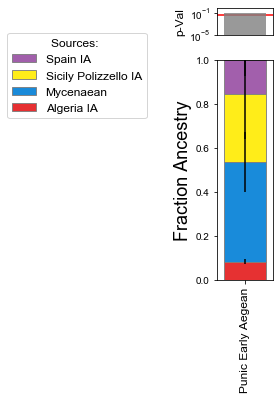

In [138]:
### Load the ancient Individual Label Data

t = "PunicCentralMedEarly"
sources = ["Algeria_IA", "Greece_BA_Mycenaean", "Italy_Sicily_IA_Polizzello", "Spain_IA"]
paths = [".".join([t]+sources)]

dir_path = f"./output/qpAdm/v49.2/area51/"
save_path = "" # ./figures/qpAdm/v44/4way_Canaanite.pdf
c = ["#e41a1c", "#007ED6", "#FFEC00", "#984ea3", "gray"]

xlabels = ["Punic Early Aegean"]
plot_qpadm(dir_path=dir_path, test_pops=paths, save_path=save_path,
           xlabels=xlabels, sort_p=True, labels=["Algeria IA", "Mycenaean", "Sicily Polizzello IA", "Spain IA"],
           best=False, pval_lim = [1e-5,1], figsize=(1,5), bw=0.9, lw=1.5, 
           fs=12, c=c, ec="gray", l_pos=(-1.15, 1.15))

# Area 51

### Try out single models

In [120]:
%%time

target = "Israel_C"  
sources = ["Levant_N", "Iran_N", "Anatolia_N"]  # Morocco_EN.SG, Algeria_IA

rightpops = ['Mota', 'Ust_Ishim', 'Kostenki14', 'GoyetQ116-1',
             'Vestonice16', 'MA1', 'ElMiron', 'Villabruna',
             'EHG', 'CHG', 'Natufian', "Morocco_EN.SG"]

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 54.134359
CPU times: user 3.41 ms, sys: 11.7 ms, total: 15.1 ms
Wall time: 54.1 s


0

In [132]:
%%time

target = "Israel_C"  
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "Tunisia_LN", "Iran_N", "Levant_N"] # Morocco_EN.SG, Algeria_IA
rightpops = ['Mota', 'Ust_Ishim', 'Kostenki14', 'GoyetQ116-1',
             'Vestonice16', 'MA1', 'ElMiron', 'Villabruna',
             'EHG', 'CHG', 'Natufian', "Morocco_EN.SG"]

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 84.836933
CPU times: user 6.06 ms, sys: 8.55 ms, total: 14.6 ms
Wall time: 1min 24s


0

# 1-way model from Tunisia_LN to Algeria_IA
Does not really fit

In [18]:
%%time

target = "Algeria_IA"  
sources = ["Tunisia_LN"] # Morocco_EN.SG, Algeria_IA
rightpops = ['Mota', 'Ust_Ishim', 'Kostenki14', 'GoyetQ116-1',
             'Vestonice16', 'MA1', 'ElMiron', 'Villabruna',
             'EHG', 'CHG', 'Natufian', "Morocco_EN.SG"]

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 46.118396
CPU times: user 6.69 ms, sys: 5.5 ms, total: 12.2 ms
Wall time: 46.1 s


0

# Sow 2-way model from Tunisia_LN to Algeria_IA
Does not really fit, so try Israel_C as second source.
That is also seen on the African PCA - there is a further shift not seen yet in Tunisia_LN.
Still not excellent fit - but better (p=10e-5)

In [19]:
%%time

target = "Algeria_IA"  
sources = ["Tunisia_LN", "Israel_C", ] # Morocco_EN.SG, Algeria_IA
rightpops = ['Mota', 'Ust_Ishim', 'Kostenki14', 'GoyetQ116-1',
             'Vestonice16', 'MA1', 'ElMiron', 'Villabruna',
             'EHG', 'CHG', 'Natufian', "Morocco_EN.SG"]

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 50.525968
CPU times: user 2.11 ms, sys: 9.02 ms, total: 11.1 ms
Wall time: 50.5 s


0

In [20]:
%%time

target = "Algeria_IA"  
sources = ["Tunisia_EN", "Israel_C", ] # Morocco_EN.SG, Algeria_IA
rightpops = ['Mota', 'Ust_Ishim', 'Kostenki14', 'GoyetQ116-1',
             'Vestonice16', 'MA1', 'ElMiron', 'Villabruna',
             'EHG', 'CHG', 'Natufian', "Morocco_EN.SG"]

leftpops = [target] + sources
qpAdm_run(leftpops = leftpops, rightpops = rightpops, 
          output_file = ".".join(leftpops), 
          input_folder = "./eigenstrat/", 
          input_file = "anc_only.v49.2",
          input_ind_suff = ".punic_early",
          par_file_folder = "./parfiles/", 
          output_folder = "./output/qpAdm/v49.2/area51/", 
          path_bin_qpAdm = "/n/groups/reich/hringbauer/git/AdmixTools/bin/qpAdm",
          all_snps=False)

Runtime: 50.504099
CPU times: user 6.22 ms, sys: 6.88 ms, total: 13.1 ms
Wall time: 50.5 s


0